# Sentiment Analysis

The project aims at doing **polarity classification** using various methods on movie reviews.
Motivation:
   - Recommendation system
   - Scalable market analysis
   - Capture nuanced opinions

# Data Understanding
- Source: [Rotten Tomatoes movies and critic reviews dataset | Kaggle](https://www.kaggle.com/datasets/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset)
- Extracted using selenium python library
- Key features:
    - Reviews
        - **rotten_tomatoes_link** : Movie ID
        - **critic_name** : User name
        - **review_score** : Review rating for the movie
        - **review_content** : Review string
    - Movies
        - **rotten_tomatoes_link** : Movie ID
        - **movie_title** : Movie title

In [12]:
# ruff: noqa: E402
import pandas as pd

df_reviews = pd.read_csv("./data/raw/rotten_tomatoes_critic_reviews.csv")
df_movies = pd.read_csv("./data/raw/rotten_tomatoes_movies.csv")

In [2]:
# Remove reviews with null scores or content
df_reviews = df_reviews.dropna(subset=["review_score", "review_content"])
print(f"Reviews {df_reviews.shape}")
print(f"Movies {df_movies.shape}")

Reviews (758709, 8)
Movies (17712, 22)


In [3]:
df_reviews.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
6,m/0814255,Nick Schager,False,Slant Magazine,Rotten,1/4,2010-02-10,Harry Potter knockoffs don't come more transpa...
7,m/0814255,Bill Goodykoontz,True,Arizona Republic,Fresh,3.5/5,2010-02-10,"Percy Jackson isn't a great movie, but it's a ..."
8,m/0814255,Jordan Hoffman,False,UGO,Fresh,B,2010-02-10,"Fun, brisk and imaginative"
9,m/0814255,Jim Schembri,True,The Age (Australia),Fresh,3/5,2010-02-10,"Crammed with dragons, set-destroying fights an..."


- The review scores come in 2 forms:
    - A fractional string (A/B; A & B are integers)
    - An alphabet grade (A+ to F; highest to lowest, respectively)

## Data processing
- Transform scores to polarity score (+ve/-ve)
    - Represent alphabetical scores with numbers 0 to 12
    - Normalize scores to 0-1
    - Remove erroneous scores; divided by 0 or higher than 1
    - Assign polarity
      -  1 (positive) to >= 0.7
      - -1 (negative) to <= 0.4
      -  0 (neutral) otherwise

In [4]:
from fractions import Fraction
from typing import Union

import numpy as np

GRADES = {
    "A+": 12,
    "A": 11,
    "A-": 10,
    "B+": 9,
    "B": 8,
    "B-": 7,
    "C+": 6,
    "C": 5,
    "C-": 4,
    "D+": 3,
    "D": 2,
    "D-": 1,
    "F": 0,
}


def normalize_score(score: str) -> Union[int, float]:
    if "/" in score:
        try:
            num, den = score.split("/")
            num = float(Fraction(num))
            den = float(Fraction(den))
            if den > 0:
                return num / den
            else:
                return np.nan
        except Exception:
            return np.nan

    # Some scores has whitespace (e.g., B    -)
    score = score.replace(" ", "")

    # Letter grade
    if score in GRADES:
        return GRADES[score] / 12

    # Some values are numeric without "/", ignore them
    return np.nan


df_reviews["score_norm"] = df_reviews["review_score"].apply(normalize_score)

df_reviews = df_reviews.dropna(subset=["score_norm"])

# Filter out erroneous scores (e.g. 8/5)
df_reviews = df_reviews[df_reviews["score_norm"] <= 1]

# Transform to +ve -ve scores
df_reviews["polarity"] = df_reviews["score_norm"].apply(
    lambda x: 1 if x >= 0.7 else 0 if x <= 0.4 else -1
)

In [ ]:
import spacy
from tqdm import tqdm

tqdm.pandas()  # enables df.progress_apply()

# Words to keep for sentiment analysis
keep_words = {
    "not",
    "no",
    "never",
    "none",
    "nothing",
    "neither",
    "nor",
    "very",
    "really",
    "too",
    "so",
    "quite",
    "extremely",
    "least",
    "barely",
    "hardly",
}

# Download the English model
# python -m space en_core_web_sm
nlp = spacy.load("en_core_web_sm")

sentiment_stopwords = nlp.Defaults.stop_words - keep_words


# Remove stopwords and
def preprocess_review(text):
    doc = nlp(text)
    tokens = [
        token.lemma_.lower()
        for token in doc
        if token.lemma_.lower() not in sentiment_stopwords and token.is_alpha
    ]
    return " ".join(tokens)


df_reviews["processed_review"] = df_reviews["review_content"].progress_apply(
    preprocess_review
)

df_reviews.to_csv(
    "./data/processed/rotten_tomatoes_critic_reviews.csv",
    index=False,
)

In [25]:
df_reviews = pd.read_csv("./data/processed/rotten_tomatoes_critic_reviews.csv")

In [26]:
counts = df_reviews["polarity"].value_counts()
percentages = (counts / len(df_reviews) * 100).round(2)

from IPython.display import display

pd.DataFrame({"count": counts, "percentage": percentages})

,count,percentage
polarity,,
1,336999,44.51
0,270390,35.72
-1,149683,19.77


Downsample & only consider +ve & -ve polarities only

In [27]:
df_reviews = df_reviews.dropna(subset=["processed_review"])
df_reviews = df_reviews[df_reviews["polarity"] != 0]

n = df_reviews["polarity"].value_counts().min()

pos_samples = df_reviews[df_reviews["polarity"] == 1].sample(n, random_state=42)
neg_samples = df_reviews[df_reviews["polarity"] == -1].sample(n, random_state=42)

df_reviews_subset = pd.concat([pos_samples, neg_samples], ignore_index=True)
df_reviews_subset = df_reviews_subset.sample(frac=1).reset_index(drop=True)
df_reviews_subset.to_csv(
    "./data/processed/rotten_tomatoes_critic_reviews_subset.csv",
    index=False,
)

In [28]:
import pandas as pd

df_reviews_subset = pd.read_csv(
    "./data/processed/rotten_tomatoes_critic_reviews_subset.csv"
)
df_movies = pd.read_csv("./data/raw/rotten_tomatoes_movies.csv")

## Visualizations
- Length of reviews & polarity distribution
- Normalized score distribution
- Review frequency & sentiment for top movies

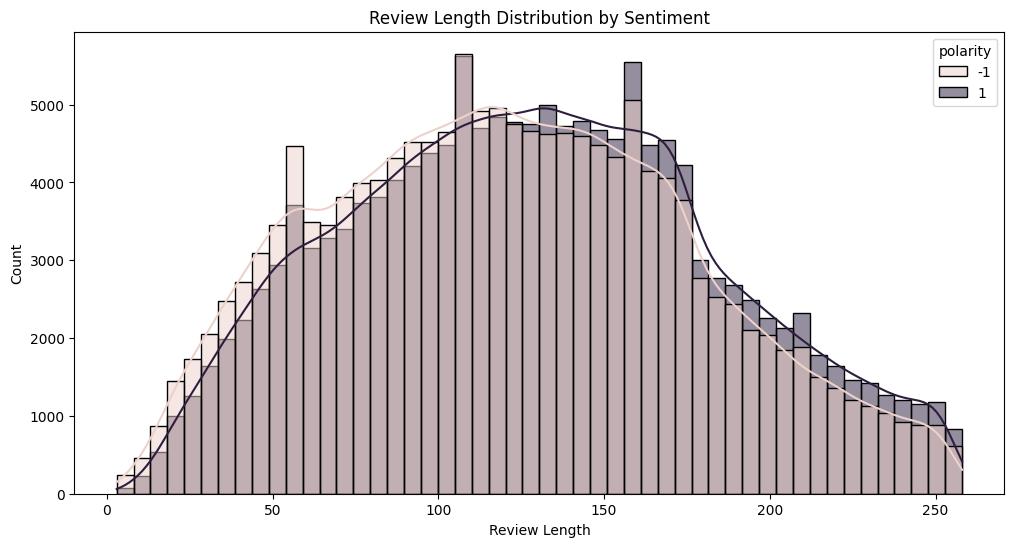

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

df_reviews_subset["review_length"] = df_reviews_subset["review_content"].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_reviews_subset, x="review_length", hue="polarity", bins=50, kde=True
)
plt.title("Review Length Distribution by Sentiment")
plt.xlabel("Review Length")
plt.show()

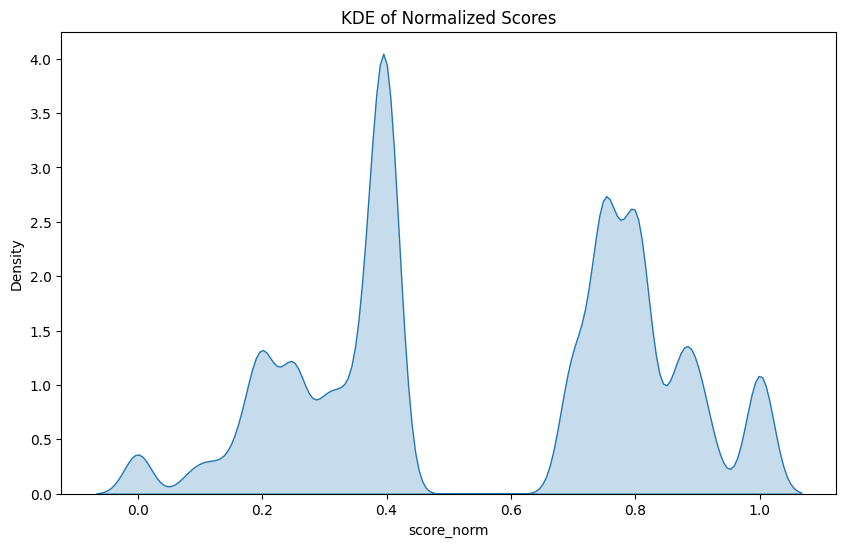

In [30]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_reviews_subset["score_norm"], fill=True)
plt.title("KDE of Normalized Scores")
plt.show()

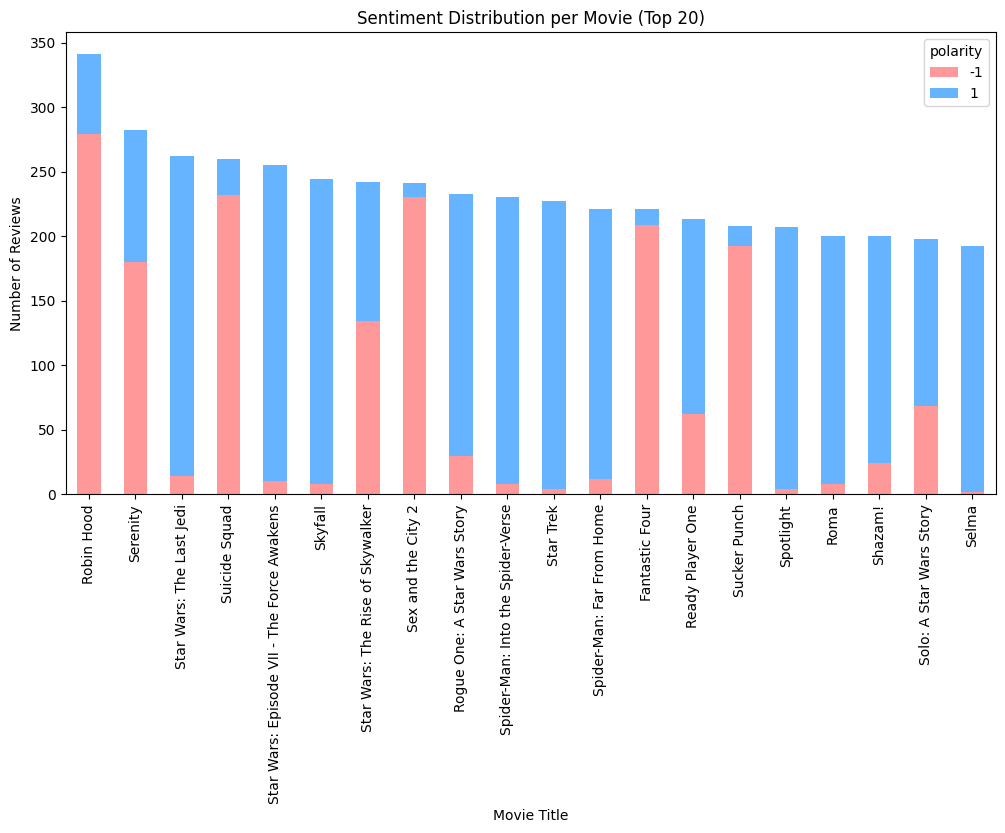

In [31]:
df = pd.merge(
    df_reviews_subset,
    df_movies,
    left_on="rotten_tomatoes_link",
    right_on="rotten_tomatoes_link",
    how="inner",
)
movie_sentiment = (
    df.groupby(["movie_title", "polarity"])["review_content"]
    .count()
    .unstack(fill_value=0)
)
top_movies = movie_sentiment.sum(axis=1).sort_values(ascending=False).head(20)

movie_sentiment_top = movie_sentiment.loc[top_movies.index]

colors = ["#ff9999", "#66b3ff"]
movie_sentiment_top.plot(kind="bar", stacked=True, figsize=(12, 6), color=colors)
plt.title("Sentiment Distribution per Movie (Top 20)")
plt.ylabel("Number of Reviews")
plt.xlabel("Movie Title")
plt.xticks(rotation=90)
plt.show()

# Methods for polarity classification
  - Rule-based
  - Classical machine learning
  - Neural network

## Rule-based model
Valence Aware Dictionary and sEntiment Reasoner (VADER)
  - Valence score: emotional measurement
  - Lexicon: average of 10 independent human raters [-4, +4]
  - Specialized for Social media
  - Compound: Summing words valence scores; adjusted to rules; normalized between -1 & 1
  - [Paper](https://ojs.aaai.org/index.php/ICWSM/article/view/14550) & [git repository](https://github.com/cjhutto/vaderSentiment/)

In [32]:
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Generated with help of LLMs
# E.g.: cliche, shallow, atmospheric, cringe, wooden, rushed
with open("./movie_lexicon.json", "r", encoding="utf-8") as f:
    extra_lexicon = json.load(f)

analyzer = SentimentIntensityAnalyzer()
analyzer.lexicon.update(extra_lexicon)

SENTENCES = [
    "I like this movie.",
    "I love this movie.",  # Different weights on words
    "I love this movie!",  # Punctuation & emoticons
    "I love this movie! 😍",  # Emojis
    "I LOVE this movie!",  # Capitalization emphasis
    "I really love this movie!!!",  # Repeated punctuation & intensifier
    "I don't love this movie.",  # Negation with contraction
    "This movie is okay.",  # Neutral sentiment
]

results = []

for sentence in SENTENCES:
    score = analyzer.polarity_scores(sentence)
    results.append(
        {
            "Sentence": sentence,
            "Compound Score": score["compound"],
            "Positive": score["pos"],
            "Neutral": score["neu"],
            "Negative": score["neg"],
        }
    )

df = pd.DataFrame(results)
df

,Sentence,Compound Score,Positive,Neutral,Negative
0,I like this movie.,0.3612,0.455,0.545,0.000
1,I love this movie.,0.6369,0.583,0.417,0.000
2,I love this movie!,0.6696,0.600,0.400,0.000
3,I love this movie! 😍,0.8172,0.555,0.445,0.000
4,I LOVE this movie!,0.7371,0.635,0.365,0.000
5,I really love this movie!!!,0.7483,0.573,0.427,0.000
6,I don't love this movie.,-0.5216,0.000,0.543,0.457
7,This movie is okay.,0.2263,0.388,0.612,0.000


In [33]:
from collections import Counter
from tqdm import tqdm
import re

tqdm.pandas()  # enables df.progress_apply()


def tokenize(text: str) -> str:
    return re.findall(r"\b\w+\b", text.lower())


# Remove full movie title from text
def remove_movie_title(text: str, title: str) -> str:
    # Case-insensitive removal
    return re.sub(re.escape(title), "", text, flags=re.IGNORECASE).strip()


def vader_sentiment_with_word_counts(text: str, title: str) -> pd.Series:
    """Return valience score & words contributing to it"""
    clean_text = remove_movie_title(text, title)
    words = tokenize(clean_text)
    pos_counter, neg_counter = Counter(), Counter()
    for word in words:
        if word in analyzer.lexicon:
            score = analyzer.lexicon[word]
            if score > 0:
                pos_counter[word] += 1
            elif score < 0:
                neg_counter[word] += 1
    scores = analyzer.polarity_scores(text)
    return pd.Series(
        {
            "compound": scores["compound"],
            "pos_words": pos_counter,
            "neg_words": neg_counter,
        }
    )


df = pd.merge(
    df_movies[["movie_title", "rotten_tomatoes_link"]],
    df_reviews_subset,
    left_on="rotten_tomatoes_link",
    right_on="rotten_tomatoes_link",
    how="inner",
)

# Apply per review
df_sentiment = df.join(
    df.progress_apply(
        lambda x: vader_sentiment_with_word_counts(
            x["review_content"], x["movie_title"]
        ),
        axis=1,
    )
)

100%|███████████████████████████████████████████████████████████████████████████████| 299136/299136 [01:51<00:00, 2673.39it/s]


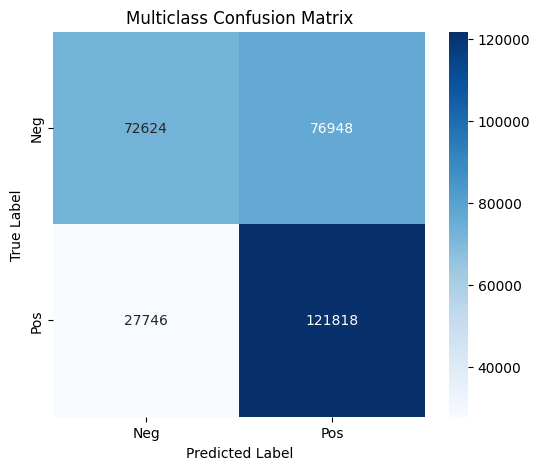

Accuracy: 0.65
Precision: 0.61
Recall:    0.81
F1-score:  0.70


In [34]:
df_sentiment["pred_polarity"] = df_sentiment["compound"].apply(
    lambda x: 1 if x >= 0 else -1
)


def merge_counters(counters):
    result = Counter()
    for c in counters:
        result.update(c)
    return result.most_common(5)


agg_df = (
    df_sentiment.groupby("movie_title")
    .agg(
        num_reviews=("review_content", "count"),
        mean_compound=("compound", "mean"),
        pos_words=("pos_words", merge_counters),
        neg_words=("neg_words", merge_counters),
        mean_polarity=("polarity", "mean"),
        mean_pred_polarity=("pred_polarity", "mean"),
        accuracy_polarity=(
            "pred_polarity",
            lambda x: (x == df_sentiment.loc[x.index, "polarity"]).mean(),
        ),  # per-movie accuracy
    )
    .reset_index()
)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

df_sentiment = df_sentiment.dropna(subset=["pred_polarity"])
# Overall metrics
y_true = df_sentiment["polarity"]
y_pred = df_sentiment["pred_polarity"]

accuracy = (y_true == y_pred).mean()
cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Heatmap for confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Neg", "Pos"],
    yticklabels=["Neg", "Pos"],
)
plt.title("Multiclass Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1-score:  {f1:.2f}")

In [35]:
pd.set_option("display.max_colwidth", None)
agg_df.sort_values(by="num_reviews", ascending=False).reset_index(drop=True).head()

,movie_title,num_reviews,mean_compound,pos_words,neg_words,mean_polarity,mean_pred_polarity,accuracy_polarity
0,Robin Hood,341,-0.013776,"[(like, 28), (good, 17), (adventure, 12), (fun, 11), (great, 10)]","[(forget, 26), (no, 21), (worst, 15), (fails, 10), (boring, 10)]",-0.636364,0.073314,0.563050
1,Serenity,282,0.082913,"[(like, 24), (good, 17), (best, 14), (thriller, 10), (silly, 8)]","[(bad, 18), (no, 16), (mess, 14), (worst, 10), (wars, 9)]",-0.276596,0.234043,0.631206
2,Star Wars: The Last Jedi,262,0.298366,"[(best, 30), (like, 17), (good, 14), (fun, 13), (great, 12)]","[(wars, 82), (strikes, 15), (no, 13), (leave, 5), (lost, 4)]",0.893130,0.442748,0.713740
3,Suicide Squad,260,-0.282324,"[(good, 33), (like, 30), (fun, 13), (blockbuster, 10), (better, 8)]","[(bad, 38), (no, 28), (worst, 12), (mess, 10), (waste, 8)]",-0.784615,-0.323077,0.723077
4,Star Wars: Episode VII - The Force Awakens,255,0.408738,"[(original, 31), (fun, 22), (like, 22), (best, 21), (good, 19)]","[(wars, 106), (no, 10), (strikes, 6), (hard, 6), (villains, 3)]",0.921569,0.701961,0.843137


In [37]:
df_sentiment[df_sentiment["polarity"] != df_sentiment["pred_polarity"]][
    [
        "movie_title",
        "review_score",
        "review_content",
        "score_norm",
        "polarity",
        "compound",
        "pos_words",
        "neg_words",
        "pred_polarity",
    ]
].head()

,movie_title,review_score,review_content,score_norm,polarity,compound,pos_words,neg_words,pred_polarity
1,Percy Jackson & the Olympians: The Lightning Thief,2/5,Some moments of inspired silliness save this escapist adventure from complete dullness.,0.40,-1,0.6597,"{'inspired': 1, 'save': 1, 'adventure': 1}","{'silliness': 1, 'dullness': 1}",1
3,Percy Jackson & the Olympians: The Lightning Thief,1/4,Whew boy.,0.25,-1,0.0000,{},{},1
4,Percy Jackson & the Olympians: The Lightning Thief,2/5,Digitisation reigns - spectacular visual effects - while the dialogue drizzles and sploshes.,0.40,-1,0.0000,{},{},1
8,Percy Jackson & the Olympians: The Lightning Thief,2/5,It kind of just builds up to a lot of Not Much.,0.40,-1,0.0000,{'kind': 1},{},1
12,Percy Jackson & the Olympians: The Lightning Thief,3/10,This film is replete with plot holes.,0.30,-1,0.0000,{},{},1


### Limitations
- Doesn't understand context, idioms, sarcasm, irony, etc.
- Intensive manual labor
- Hard to generalize
- Low accuracy compared to other methods
- Can't learn from data

## Classical machine learning
- Models:
    - Linear suppoer vector classifier
    - Logistic regression
    - Naive bayes
- Embeddings: 
    - Bag of words for unigrams & bigrams
    - TF-IDF for unigrams & bigrams

In [38]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from typing import List, Dict

df_reviews_subset = df_reviews_subset.dropna(subset=["review_content"])
X = df_reviews_subset["processed_review"]
y = df_reviews_subset["polarity"]


def evaluate_model_cv(model, vectorizer, X, y, cv_splits=5) -> List[Dict[str, int]]:
    """
    Perform manual KFold CV on a model + vectorizer.
    Returns a dict with aggregated metrics.
    """

    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=42)

    fold_metrics = []

    for fold, (train_idx, test_idx) in enumerate(
        tqdm(kf.split(X), total=kf.get_n_splits(), desc="Cross-validation")
    ):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)

        model.fit(X_train_vec, y_train)

        preds = model.predict(X_test_vec)

        fold_metrics.append(
            {
                "fold": fold,
                "accuracy": accuracy_score(y_test, preds),
                "precision": precision_score(
                    y_test, preds
                ),
                "recall": recall_score(
                    y_test, preds
                ),
                "f1": f1_score(y_test, preds),
            }
        )

    return fold_metrics

vectorizers = {
    "BOW": CountVectorizer(ngram_range=(1, 2)),
    "TF-IDF": TfidfVectorizer(ngram_range=(1, 2)),
}

models = {
    "Linear SVC": LinearSVC(),
    "LR": LogisticRegression(C=1, max_iter=500),
    "NB": MultinomialNB(),
}

results = []

for vec_name, vec in vectorizers.items():
    for model_name, model in models.items():
        print(f"Vectorizer: {vec_name}\nModel: {model_name}")
        folds = evaluate_model_cv(model, vec, X, y)
        for f in folds:
            results.append({"vectorizer": vec_name, "model": model_name, **f})

df_results = pd.DataFrame(results)

Vectorizer: BOW
Model: Linear SVC


Cross-validation: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [03:34<00:00, 42.93s/it]


Vectorizer: BOW
Model: LR


Cross-validation: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [03:48<00:00, 45.67s/it]


Vectorizer: BOW
Model: NB


Cross-validation: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.16s/it]


Vectorizer: TF-IDF
Model: Linear SVC


Cross-validation: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [01:05<00:00, 13.04s/it]


Vectorizer: TF-IDF
Model: LR


Cross-validation: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.31s/it]


Vectorizer: TF-IDF
Model: NB


Cross-validation: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.36s/it]


,model,vectorizer,acc_mean,acc_std,prec_mean,prec_std,rec_mean,rec_std,f1_mean,f1_std
0,LR,BOW,0.8631,0.0025,0.8657,0.0046,0.8594,0.0026,0.8626,0.0029
1,LR,TF-IDF,0.8453,0.0030,0.8353,0.0052,0.8601,0.0019,0.8475,0.0031
2,Linear SVC,BOW,0.8571,0.0016,0.8592,0.0032,0.8541,0.0029,0.8567,0.0019
3,Linear SVC,TF-IDF,0.8649,0.0028,0.8555,0.0041,0.8782,0.0028,0.8667,0.0031
4,NB,BOW,0.8572,0.0026,0.8541,0.0040,0.8617,0.0020,0.8578,0.0029
5,NB,TF-IDF,0.8570,0.0028,0.8498,0.0049,0.8673,0.0021,0.8584,0.0030


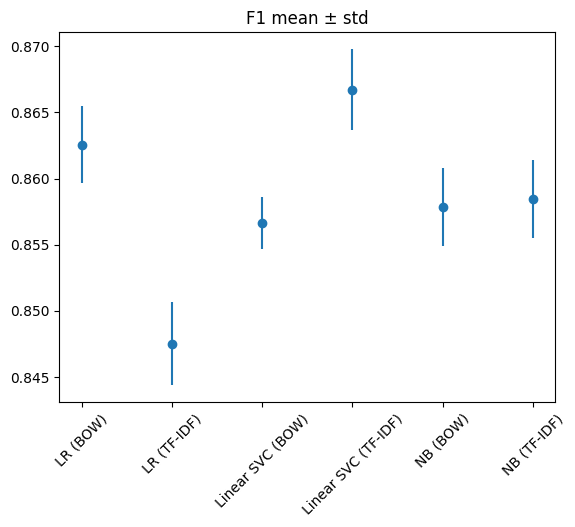

In [40]:
import matplotlib.pyplot as plt

summary = (
    df_results.groupby(["model", "vectorizer"])
    .agg(
        acc_mean=("accuracy", "mean"),
        acc_std=("accuracy", "std"),
        prec_mean=("precision", "mean"),
        prec_std=("precision", "std"),
        rec_mean=("recall", "mean"),
        rec_std=("recall", "std"),
        f1_mean=("f1", "mean"),
        f1_std=("f1", "std"),
    )
    .reset_index()
)
from IPython.display import display

summary = summary.round(4)
display(summary)
summary = (
    df_results.groupby(["model", "vectorizer"])
    .agg(mean_f1=("f1", "mean"), std_f1=("f1", "std"))
    .reset_index()
)
plt.errorbar(
    x=summary["model"] + " (" + summary["vectorizer"] + ")",
    y=summary["mean_f1"],
    yerr=summary["std_f1"],
    fmt="o",
)
plt.xticks(rotation=45)
plt.title("F1 mean ± std")
plt.show()

# Neural networks
Bidirectional LSTM
- Embeddings:
    - Ordinal
    - DistillBERT

[[    0     0     0 ...     3  1330  3529]
 [    0     0     0 ...   241   367   772]
 [    0     0     0 ...    36  1005  2134]
 ...
 [    0     0     0 ... 13018     1  5432]
 [    0     0     0 ...   137  7209 37922]
 [    0     0     0 ...   143   318 21608]]
X shape: (299162, 55), Y shape: (299162, 2)

Data split:
X_train shape: (191463, 55), Y_train shape: (191463, 2)
X_val shape: (47866, 55), Y_val shape: (47866, 2)
X_test shape: (59833, 55), Y_test shape: (59833, 2)

Percentages: Train=64.0%, Val=16.0%, Test=20.0%
Using device: cuda
LSTMSentimentModel(
  (embedding): Embedding(50000, 256, padding_idx=0)
  (spatial_dropout): Dropout2d(p=0.4, inplace=False)
  (lstm): LSTM(256, 196, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=392, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 14437778
Epoch 1/10 - loss: 0.5232 - acc: 0.7268 - val_loss: 0.4038 - val_acc: 0.8167
Epoch 2/10 - loss: 0.3722 - acc: 0.8295 - val_los

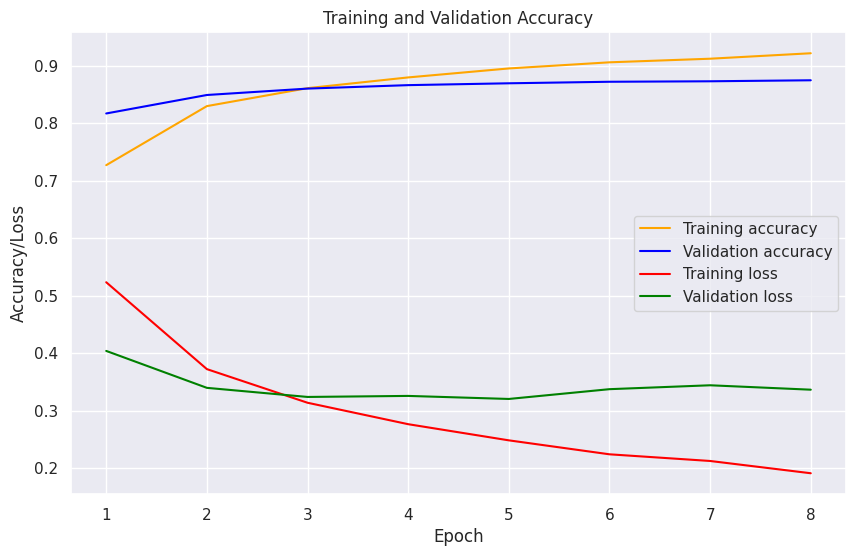


Test Set Evaluation:
Test Loss: 0.3165
Test Accuracy: 0.8713

Confusion Matrix:
[[26473  3443]
 [ 4216 25701]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     29916
           1       0.88      0.86      0.87     29917

    accuracy                           0.87     59833
   macro avg       0.87      0.87      0.87     59833
weighted avg       0.87      0.87      0.87     59833



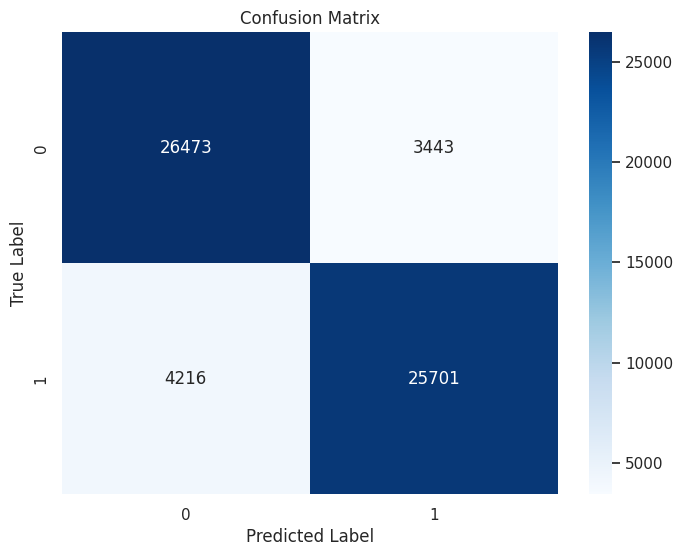

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Text Preprocessing 
class TextTokenizer:
    def __init__(self, num_words=None):
        self.num_words = num_words
        self.word_index = {}
        self.index_word = {}

    def fit_on_texts(self, texts):
        """Build vocabulary from texts"""
        word_counts = Counter()
        for text in texts:
            words = text.lower().split()
            word_counts.update(words)

        # Get most common words
        most_common = word_counts.most_common(
            self.num_words - 1 if self.num_words else None
        )

        # Create word_index (starting from 1; 0 is reserved for padding)
        self.word_index = {word: idx + 1 for idx, (word, _) in enumerate(most_common)}
        self.index_word = {idx: word for word, idx in self.word_index.items()}

    def texts_to_sequences(self, texts):
        """Convert texts to sequences of integers"""
        sequences = []
        for text in texts:
            words = text.lower().split()
            seq = [
                self.word_index.get(word, 0)
                for word in words
                if word in self.word_index
            ]
            sequences.append(seq)
        return sequences


def pad_sequences(sequences, maxlen=None, padding="pre", value=0):
    """Pad sequences to the same length"""
    # Filter out empty sequences for maxlen calculation
    non_empty_sequences = [seq for seq in sequences if len(seq) > 0]

    if maxlen is None:
        if len(non_empty_sequences) > 0:
            maxlen = max(len(seq) for seq in non_empty_sequences)
        else:
            maxlen = 1  # Default to 1 if all sequences are empty

    padded = np.zeros((len(sequences), maxlen), dtype=np.int64)

    for i, seq in enumerate(sequences):
        if len(seq) == 0:
            # Empty sequence - will remain as zeros (padding)
            continue
        elif len(seq) > maxlen:
            if padding == "pre":
                padded[i] = seq[-maxlen:]
            else:
                padded[i] = seq[:maxlen]
        else:
            if padding == "pre":
                padded[i, -len(seq) :] = seq
            else:
                padded[i, : len(seq)] = seq

    return padded


# Data Preprocessing
x = df_reviews_subset["review_content"].values

max_features = 50000

tokenizer = TextTokenizer(num_words=max_features)
tokenizer.fit_on_texts(x)
X = tokenizer.texts_to_sequences(x)
X = pad_sequences(X)
Y = pd.get_dummies(df_reviews_subset["polarity"]).values


print(X)
print(f"X shape: {X.shape}, Y shape: {Y.shape}")

# Train/Validation/Test Split
X_temp, X_test, Y_temp, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=0.2, random_state=42, stratify=Y_temp
)

print(f"\nData split:")
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")
print(
    f"\nPercentages: Train={len(X_train) / len(X) * 100:.1f}%, Val={len(X_val) / len(X) * 100:.1f}%, Test={len(X_test) / len(X) * 100:.1f}%"
)

# Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.LongTensor(X)
        self.Y = torch.FloatTensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


# LSTM Model
class LSTMSentimentModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, lstm_hidden, num_classes, dropout=0.2):
        super(LSTMSentimentModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.spatial_dropout = nn.Dropout2d(0.4)

        self.lstm = nn.LSTM(
            embed_dim,
            lstm_hidden,
            batch_first=True,
            num_layers=2,
            dropout=dropout,
            bidirectional=True,
        )

        self.fc = nn.Linear(lstm_hidden * 2, num_classes)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)

        embedded = embedded.permute(0, 2, 1).unsqueeze(3)
        embedded = self.spatial_dropout(embedded)
        embedded = embedded.squeeze(3).permute(0, 2, 1)

        lstm_out, (hidden, cell) = self.lstm(embedded)

        # hidden shape: (num_layers, batch, hidden)
        # Take the last layer's hidden state
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)

        output = self.fc(hidden)
        output = self.sigmoid(output)

        return output

# Training Setup
embed_dim_out = 256
lstm_out = 196
num_classes = Y.shape[1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = LSTMSentimentModel(
    vocab_size=max_features,
    embed_dim=embed_dim_out,
    lstm_hidden=lstm_out,
    num_classes=num_classes,
    dropout=0.2,
).to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

# Create Data Loaders
train_dataset = SentimentDataset(X_train, Y_train)
val_dataset = SentimentDataset(X_val, Y_val)
test_dataset = SentimentDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training Loop with Early Stopping
criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = optim.Adam(model.parameters())

# Early stopping parameters
patience = 3
min_delta = 1e-3
best_val_loss = float("inf")
patience_counter = 0
epochs = 10

history = {"accuracy": [], "val_accuracy": [], "loss": [], "val_loss": []}

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate accuracy
        predictions = (outputs > 0.5).float()
        train_correct += (predictions == batch_y).all(dim=1).sum().item()
        train_total += batch_y.size(0)

    train_loss /= len(train_loader)
    train_acc = train_correct / train_total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            val_loss += loss.item()

            predictions = (outputs > 0.5).float()
            val_correct += (predictions == batch_y).all(dim=1).sum().item()
            val_total += batch_y.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # Store history
    history["loss"].append(train_loss)
    history["accuracy"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_acc)

    print(
        f"Epoch {epoch + 1}/{epochs} - "
        f"loss: {train_loss:.4f} - acc: {train_acc:.4f} - "
        f"val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}"
    )

    # Early stopping check
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch + 1}")
            break

# Plot Training History
sns.set()
acc = history["accuracy"]
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, history["accuracy"], "orange", label="Training accuracy")
plt.plot(epochs_range, history["val_accuracy"], "blue", label="Validation accuracy")
plt.plot(epochs_range, history["loss"], "red", label="Training loss")
plt.plot(epochs_range, history["val_loss"], "green", label="Validation loss")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy/Loss")
plt.legend(loc="best")
plt.show()

# Test Set Evaluation with Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report

# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        test_loss += loss.item()

        predictions = (outputs > 0.5).float()
        test_correct += (predictions == batch_y).all(dim=1).sum().item()
        test_total += batch_y.size(0)

        # Store predictions and labels for confusion matrix
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

test_loss /= len(test_loader)
test_acc = test_correct / test_total

print(f"\nTest Set Evaluation:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Convert to class labels (argmax for multi-class)
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

y_pred_classes = np.argmax(all_predictions, axis=1)
y_true_classes = np.argmax(all_labels, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

Loading tokenizer and model: distilbert-base-uncased
BERT model loaded successfully!
Number of samples: 299162
Y shape: (299162, 2)

Data split:
Train: 191463 samples, Y_train shape: (191463, 2)
Val: 47866 samples, Y_val shape: (47866, 2)
Test: 59833 samples, Y_test shape: (59833, 2)

Using device: cuda
BERTLSTMSentimentModel(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_f

Epoch 1/6 [Val]  : 100%|█████████████████████████████████████████| 1496/1496 [01:46<00:00, 14.03it/s, loss=0.5126, acc=0.8179]



Epoch 1/6 Summary:
  Train - loss: 0.4395, acc: 0.7851
  Val   - loss: 0.4064, acc: 0.8179

  → Model saved (best val_loss: 0.4064)


Epoch 2/6 [Val]  : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1496/1496 [01:46<00:00, 14.02it/s, loss=0.5059, acc=0.8216]



Epoch 2/6 Summary:
  Train - loss: 0.3991, acc: 0.8134
  Val   - loss: 0.3948, acc: 0.8216

  → Model saved (best val_loss: 0.3948)


Epoch 3/6 [Val]  : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1496/1496 [01:46<00:00, 14.02it/s, loss=0.5693, acc=0.8315]



Epoch 3/6 Summary:
  Train - loss: 0.3867, acc: 0.8208
  Val   - loss: 0.3757, acc: 0.8315

  → Model saved (best val_loss: 0.3757)


Epoch 4/6 [Val]  : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1496/1496 [01:46<00:00, 14.02it/s, loss=0.5579, acc=0.8368]



Epoch 4/6 Summary:
  Train - loss: 0.3760, acc: 0.8272
  Val   - loss: 0.3612, acc: 0.8368

  → Model saved (best val_loss: 0.3612)


Epoch 5/6 [Val]  : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1496/1496 [01:46<00:00, 14.03it/s, loss=0.5142, acc=0.8420]



Epoch 5/6 Summary:
  Train - loss: 0.3660, acc: 0.8328
  Val   - loss: 0.3539, acc: 0.8420

  → Model saved (best val_loss: 0.3539)


Epoch 6/6 [Val]  : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1496/1496 [01:46<00:00, 14.02it/s, loss=0.5008, acc=0.8459]



Epoch 6/6 Summary:
  Train - loss: 0.3585, acc: 0.8371
  Val   - loss: 0.3540, acc: 0.8459



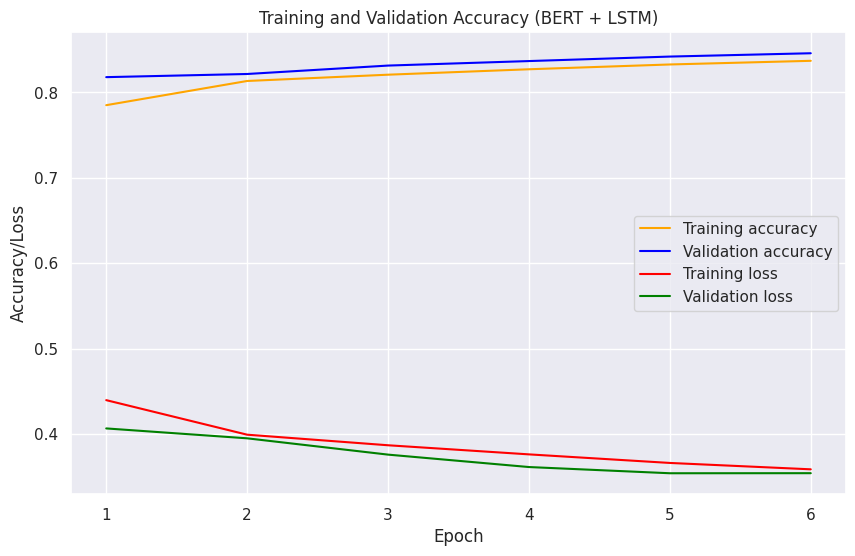

Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1870/1870 [02:13<00:00, 14.00it/s, loss=0.4864, acc=0.8418]



Test Set Evaluation:
Test Loss: 0.3517
Test Accuracy: 0.8418

Confusion Matrix:
[[25423  4493]
 [ 4836 25081]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84     29916
           1       0.85      0.84      0.84     29917

    accuracy                           0.84     59833
   macro avg       0.84      0.84      0.84     59833
weighted avg       0.84      0.84      0.84     59833



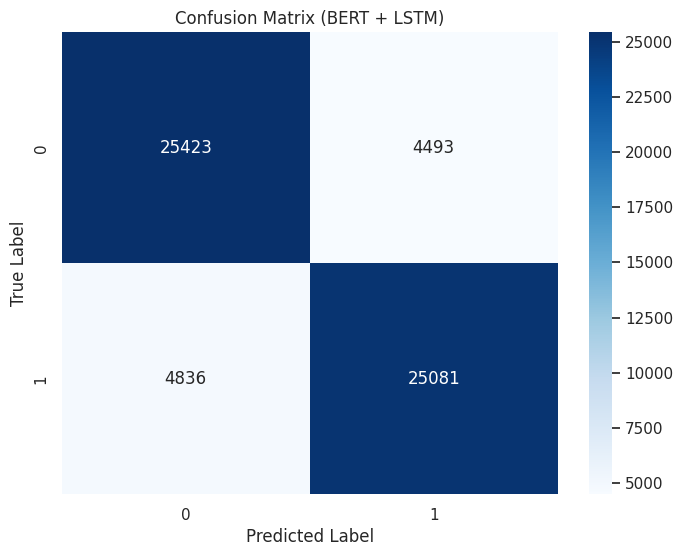

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel

# Using DistilBERT for efficiency
model_name = "distilbert-base-uncased"

print(f"Loading tokenizer and model: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

print("BERT model loaded successfully!")

# Data Preprocessing
x = df_reviews_subset["review_content"].values

Y = pd.get_dummies(df_reviews_subset["polarity"]).values

print(f"Number of samples: {len(x)}")
print(f"Y shape: {Y.shape}")

# Train/Validation/Test Split
X_temp, X_test, Y_temp, Y_test = train_test_split(
    x, Y, test_size=0.2, random_state=42, stratify=Y
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=0.2, random_state=42, stratify=Y_temp
)

print(f"\nData split:")
print(f"Train: {len(X_train)} samples, Y_train shape: {Y_train.shape}")
print(f"Val: {len(X_val)} samples, Y_val shape: {Y_val.shape}")
print(f"Test: {len(X_test)} samples, Y_test shape: {Y_test.shape}")

# Dataset Class for BERT
class BERTSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        """
        texts: array of text strings
        labels: numpy array of one-hot encoded labels
        tokenizer: BERT tokenizer
        max_length: maximum sequence length
        """
        self.texts = texts
        self.labels = torch.FloatTensor(labels)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize with BERT tokenizer
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": label,
        }

# LSTM Model with BERT Embeddings
class BERTLSTMSentimentModel(nn.Module):
    def __init__(self, bert_model, lstm_hidden, num_classes, dropout=0.2):
        super(BERTLSTMSentimentModel, self).__init__()

        self.bert = bert_model
        # DistilBERT outputs 768-dimensional vectors
        self.bert_output_dim = self.bert.config.hidden_size

        self.spatial_dropout = nn.Dropout(0.4)

        # Use num_layers=2 to make dropout work
        self.lstm = nn.LSTM(
            self.bert_output_dim,
            lstm_hidden,
            batch_first=True,
            num_layers=2,
            dropout=dropout,
            bidirectional=True,  # ← Better performance usually
        )
        self.fc = nn.Linear(lstm_hidden * 2, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        # Get BERT embeddings
        # Shape: (batch, seq_len, 768)
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        embeddings = bert_output.last_hidden_state

        embeddings = self.spatial_dropout(embeddings)

        lstm_out, (hidden, cell) = self.lstm(embeddings)

        # Use the last hidden state
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)

        # Dense layer
        output = self.fc(hidden)
        output = self.sigmoid(output)

        return output


# Training Setup
lstm_out = 196
num_classes = Y.shape[1]
max_length = 128  # Maximum sequence length for BERT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

model = BERTLSTMSentimentModel(
    bert_model=bert_model, lstm_hidden=lstm_out, num_classes=num_classes, dropout=0.2
).to(device)

# Freeze BERT parameters for faster results
for param in model.bert.parameters():
    param.requires_grad = False

print(model)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTrainable parameters: {trainable_params:,}")
print(f"Total parameters: {total_params:,}")


# Create Data Loaders
train_dataset = BERTSentimentDataset(X_train, Y_train, tokenizer, max_length)
val_dataset = BERTSentimentDataset(X_val, Y_val, tokenizer, max_length)
test_dataset = BERTSentimentDataset(X_test, Y_test, tokenizer, max_length)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nBatch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Training Loop with Early Stopping
criterion = nn.BCELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)

# Early stopping parameters
patience = 3
min_delta = 1e-3
best_val_loss = float("inf")
patience_counter = 0
epochs = 6

history = {"accuracy": [], "val_accuracy": [], "loss": [], "val_loss": []}

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [Train]")

    for batch in train_pbar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate accuracy
        predictions = (outputs > 0.5).float()
        train_correct += (predictions == labels).all(dim=1).sum().item()
        train_total += labels.size(0)

        # Update progress bar with current loss
        train_pbar.set_postfix(
            {"loss": f"{loss.item():.4f}", "acc": f"{train_correct / train_total:.4f}"}
        )

    train_loss /= len(train_loader)
    train_acc = train_correct / train_total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} [Val]  ")

    with torch.no_grad():
        for batch in val_pbar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            predictions = (outputs > 0.5).float()
            val_correct += (predictions == labels).all(dim=1).sum().item()
            val_total += labels.size(0)
            val_pbar.set_postfix(
                {"loss": f"{loss.item():.4f}", "acc": f"{val_correct / val_total:.4f}"}
            )

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # Store history
    history["loss"].append(train_loss)
    history["accuracy"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_acc)

    print(f"\nEpoch {epoch + 1}/{epochs} Summary:")
    print(f"  Train - loss: {train_loss:.4f}, acc: {train_acc:.4f}")
    print(f"  Val   - loss: {val_loss:.4f}, acc: {val_acc:.4f}\n")

    # Early stopping check
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), "best_bert_model.pth")
        print(f"  → Model saved (best val_loss: {best_val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch + 1}")
            break

# Plot Training History
sns.set()
acc = history["accuracy"]
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, history["accuracy"], "orange", label="Training accuracy")
plt.plot(epochs_range, history["val_accuracy"], "blue", label="Validation accuracy")
plt.plot(epochs_range, history["loss"], "red", label="Training loss")
plt.plot(epochs_range, history["val_loss"], "green", label="Validation loss")
plt.title("Training and Validation Accuracy (BERT + LSTM)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy/Loss")
plt.legend(loc="best")
plt.show()

# Test Set Evaluation with Confusion Matrix
# Load best model
model.load_state_dict(torch.load("best_bert_model.pth"))
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
all_predictions = []
all_labels = []

test_pbar = tqdm(test_loader, desc="Testing")

with torch.no_grad():
    for batch in test_pbar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predictions = (outputs > 0.5).float()
        test_correct += (predictions == labels).all(dim=1).sum().item()
        test_total += labels.size(0)

        test_pbar.set_postfix(
            {"loss": f"{loss.item():.4f}", "acc": f"{test_correct / test_total:.4f}"}
        )

        # Store predictions and labels for confusion matrix
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_acc = test_correct / test_total

print(f"\nTest Set Evaluation:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Convert to class labels
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

y_pred_classes = np.argmax(all_predictions, axis=1)
y_true_classes = np.argmax(all_labels, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Confusion Matrix (BERT + LSTM)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()